# Identify Heavy Traffic Indicators on I-94

### The assignment

Analyse a dataset about the westbound traffic on the I-94 Interstate highway and determine a few indicators of heavy traffic on I-94.

Potential indicators might be weather type, time of the day, time of the week, etc. 

### Data import

In [63]:
import pandas as pd
import datetime as dt

# When we use Matplotlib inside Jupyter, we need to add %matplotlip inline to enable Jupyter to generate graphs

import matplotlib.pyplot as plt
%matplotlib inline

traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

# take a first look at our data

traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [64]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [65]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


The dataset has 48,204 rows and 9 columns, and there are no null values. Each row describes traffic and weather data for a specific hour — we have data from 2012-10-02 09:00:00 until 2018-09-30 23:00:00.

### Analysing Traffic Volume

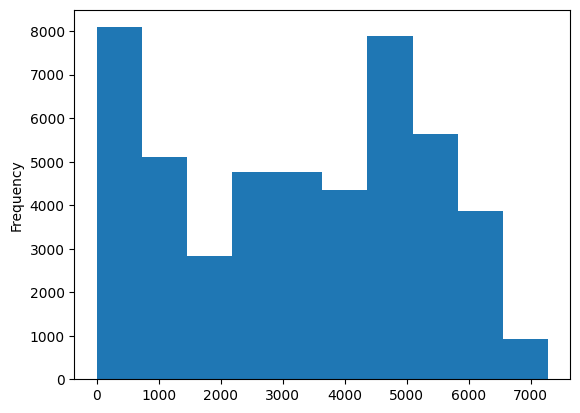

In [6]:
# do a first visual inspection of the traffic_volume column with a histogram

traffic['traffic_volume'].plot.hist()
plt.show()

In [10]:
# look at some preliminary statistics of the series

traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [11]:
# get an idea about the bin boundaries

traffic['traffic_volume'].value_counts(bins = 10).sort_index()

(-7.281000000000001, 728.0]    8095
(728.0, 1456.0]                5100
(1456.0, 2184.0]               2835
(2184.0, 2912.0]               4765
(2912.0, 3640.0]               4761
(3640.0, 4368.0]               4349
(4368.0, 5096.0]               7886
(5096.0, 5824.0]               5634
(5824.0, 6552.0]               3854
(6552.0, 7280.0]                925
Name: traffic_volume, dtype: int64

On average, about 3260 westbound vehicles per hour have been observed at station 301 between Minneapolis and St Paul. Traffic varied from 0 to 7280 cars per hour.

Frequency peaks at the lowest bin centered around 320 vehicles per hour and the bin centered around 4700 vehicles per hour stand out.

A first idea to investigate is whether nighttime traffic is lower on average than daytime traffic.

### Comparing Daytime and Nighttime Traffic Volume

Lets make the following simplistic definition:

- Daytime data spans the hours from 7 AM to 7 PM
- Nighttime data spans the hours from 7 PM to 7 AM

The date_time column is an object data type. We better convert it. 

In [66]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

#### Isolate Daytime and Nighttime Data

Daytime Data

In [55]:
daytime_traffic = traffic[(traffic['date_time'].dt.hour >= 7) & (traffic['date_time'].dt.hour < 19)]

In [58]:
daytime_traffic.shape

(23877, 9)

Nighttime Data

In [67]:
nighttime_traffic = traffic[~((traffic['date_time'].dt.hour >= 7) & (traffic['date_time'].dt.hour < 19))]

In [68]:
nighttime_traffic.shape

(24327, 9)

Daytime Traffic Histogram

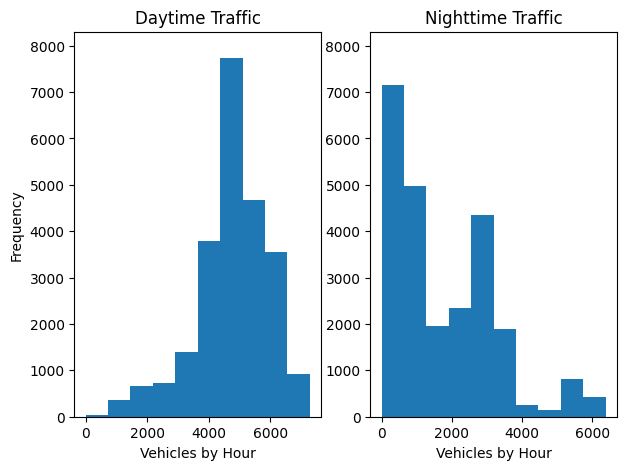

In [92]:
plt.figure(figsize = (7,5))
plt.subplot(1,2,1)
plt.hist(daytime_traffic['traffic_volume'])
plt.title('Daytime Traffic')
plt.ylabel('Frequency')
plt.ylim([0, 8300])
plt.xlabel('Vehicles by Hour')

plt.subplot(1,2,2)
plt.hist(nighttime_traffic['traffic_volume'])
plt.title('Nighttime Traffic')
plt.ylim([0, 8300])
plt.xlabel('Vehicles by Hour')

plt.show()

The Daytime Traffic histogram is centered around 5k vehicles by hour, the average being higher than for Nighttime Traffic. The daytime histogram is closer to being symmetrical, although slightly left skewed, than the nighttime traffic histogram which appears right-skewed. 

Most daytime traffic volumes are high whereas most nighttime traffic volumes are low.

Since the distributions above suggest nighttime traffic is rather light and we are interested in indicators for heavy traffic, we are going to be continuing with the daytime data only.

### Time Indicators

There might be more people on the road in a certain month, on a certain day, or at a certain time of the day. Let's investigate.

#### Let's look at average traffic per hour on a monthly basis first

In [96]:
# look at taffic volume by month

daytime_traffic['month'] = daytime_traffic['date_time'].dt.month

# group rows by month and look at average per month

by_month = daytime_traffic.groupby('month').mean(numeric_only = True)

by_month['traffic_volume']

month
1     4495.613727
2     4711.198394
3     4889.409560
4     4906.894305
5     4911.121609
6     4898.019566
7     4595.035744
8     4928.302035
9     4870.783145
10    4921.234922
11    4704.094319
12    4374.834566
Name: traffic_volume, dtype: float64

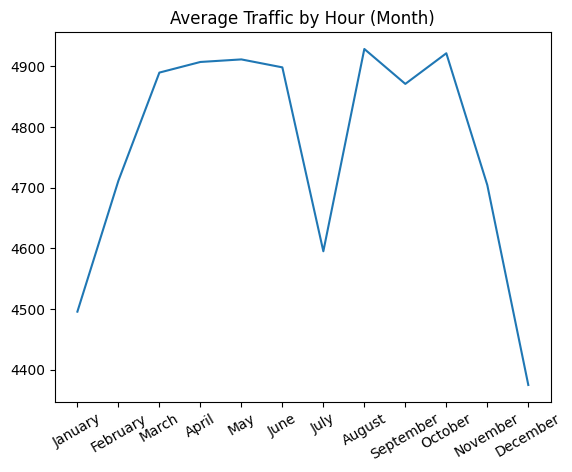

In [104]:
# generate line plot

plt.plot(by_month['traffic_volume'].index, by_month['traffic_volume'].values)
plt.xticks(ticks = range(1, 13, 1), labels = ['January', 'February', 'March',
                                              'April', 'May', 'June', 'July', 'August', 'September',
                                              'October', 'November', 'December'], rotation = 30)

plt.title('Average Traffic by Hour (Month)')
plt.show()

The lighter traffic during the colder months is not surprising. The drop in traffic per hour during July is. Is this drop-off something we can observe every year?

Let's get to the bottom of it!

#### Let's look at average traffic per hour during the Julys of our dataset

In [105]:
# look at taffic volume in July by year

daytime_traffic['year'] = daytime_traffic['date_time'].dt.year
july_only = daytime_traffic[daytime_traffic['month'] == 7]

# group rows by year and look only at the average traffic in July

by_year = july_only.groupby('year').mean(numeric_only = True)

by_year['traffic_volume']

year
2013    4914.354054
2014    4871.598240
2015    4613.146226
2016    3924.923645
2017    4734.120301
2018    4586.899543
Name: traffic_volume, dtype: float64

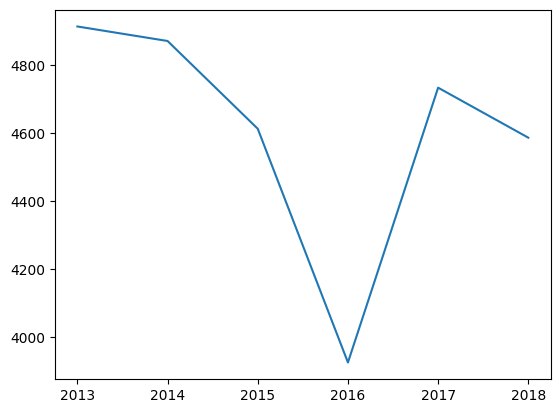

In [107]:
plt.plot(by_year['traffic_volume'].index, by_year['traffic_volume'].values)
plt.show()

We learn that July 2016 really drags down the average for the Julys in the time series. The most proximate cause one can think of is road construction going on in July 2016.

Taking this into consideration, we tentatively say that during the the warmer months of the year, we would expect to see around 4900 vehicles per hour heading West on the I-94; less during the colder months.

#### Let's take a look at average traffic volume per weekday now.

In [139]:
# look at taffic volume per weekday

daytime_traffic['day'] = daytime_traffic['date_time'].dt.weekday

by_day = daytime_traffic.groupby('day').mean(numeric_only = True)

by_day['traffic_volume']

day
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

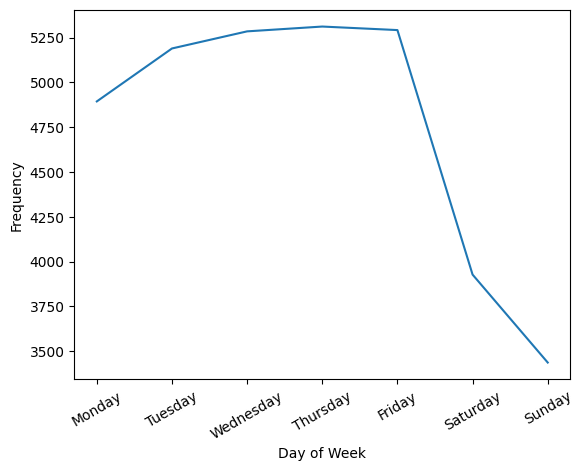

In [140]:
# plot a line chart

by_day['traffic_volume'].plot.line()
plt.xticks(ticks = range(0, 7, 1), labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation = 30)
plt.xlabel('Day of Week')
plt.ylabel('Frequency')
plt.show()

Typically, we would expect traffic volumes around or above 5000 vehicles per hour on weekdays/business days and volumes below 4000 on weekends.

#### Finally, let's look at average traffic per hour during the hours of the day

In [143]:
# look at taffic volume per hour of the day

daytime_traffic['hour'] = daytime_traffic['date_time'].dt.hour

by_hour = daytime_traffic.groupby('hour').mean(numeric_only = True)

by_hour['traffic_volume']

hour
7     4740.181337
8     4587.497115
9     4385.277502
10    4184.665544
11    4465.877561
12    4718.293095
13    4714.940682
14    4931.888776
15    5240.524302
16    5663.756539
17    5310.076048
18    4263.718530
Name: traffic_volume, dtype: float64

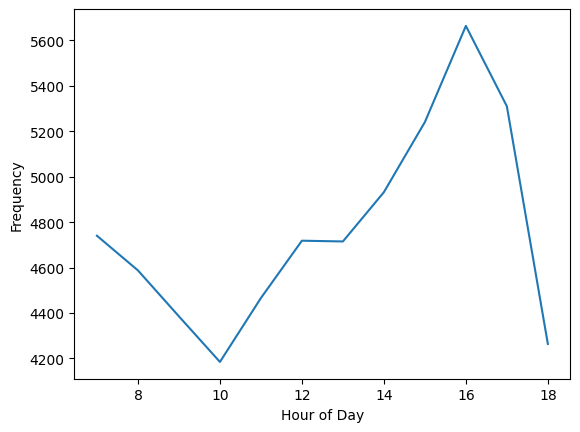

In [131]:
# plot a line chart

by_hour['traffic_volume'].plot.line()
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

The spike around 4 PM corresponds to what we'd expect as rush-hour traffic.

Let's look a little closer and separate weekday and weekend traffic and put them on a grid chart.

In [148]:
# isolate weekday traffic

# look at taffic volume per hour of the day

daytime_traffic['hour'] = daytime_traffic['date_time'].dt.hour

weekday_traffic = daytime_traffic[daytime_traffic['day'] <= 4]

by_hour_weekday = weekday_traffic.groupby('hour').mean(numeric_only = True)

by_hour_weekday['traffic_volume']

hour
7     6030.413559
8     5503.497970
9     4895.269257
10    4378.419118
11    4633.419470
12    4855.382143
13    4859.180473
14    5152.995778
15    5592.897768
16    6189.473647
17    5784.827133
18    4434.209431
Name: traffic_volume, dtype: float64

In [147]:
# isolate weekend traffic

# look at taffic volume per hour of the day

daytime_traffic['hour'] = daytime_traffic['date_time'].dt.hour

weekend_traffic = daytime_traffic[daytime_traffic['day'] > 4]

by_hour_weekend = weekend_traffic.groupby('hour').mean(numeric_only = True)

by_hour_weekend['traffic_volume']

hour
7     1589.365894
8     2338.578073
9     3111.623917
10    3686.632302
11    4044.154955
12    4372.482883
13    4362.296564
14    4358.543796
15    4342.456881
16    4339.693805
17    4151.919929
18    3811.792279
Name: traffic_volume, dtype: float64

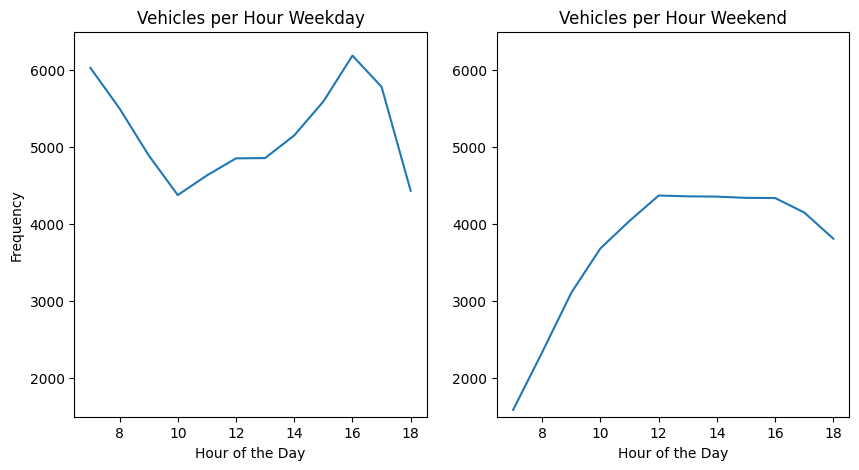

In [153]:
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
by_hour_weekday['traffic_volume'].plot.line()
plt.title('Vehicles per Hour Weekday')
plt.ylabel('Frequency')
plt.xlabel('Hour of the Day')
plt.ylim([1500, 6500])



plt.subplot(1, 2, 2)
by_hour_weekend['traffic_volume'].plot.line()
plt.title('Vehicles per Hour Weekend')
plt.xlabel('Hour of the Day')
plt.ylim([1500, 6500])

plt.show()

The separation of our data into weekdays and weekends enables better insights into traffic volumes per hour. 

Traffic volume is generally higher during business days compared to the weekends. As somehow expected, the rush hours are around 7 and 16.

What have we learnt so far:

- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to weekends.
- On business days, the rush hours are around 7 and 16.

### Weather Indicators

#### Let's start by looking at the correlations of the numerical weather columns with traffic_volume

In [156]:
daytime_traffic.corr(numeric_only = True)['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
day              -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

These correlation coefficients imply rather weak correlation between the numerical weather variables and traffic volumes. Only 'temp' seems to be worth a further look.

Let's take a closer look.

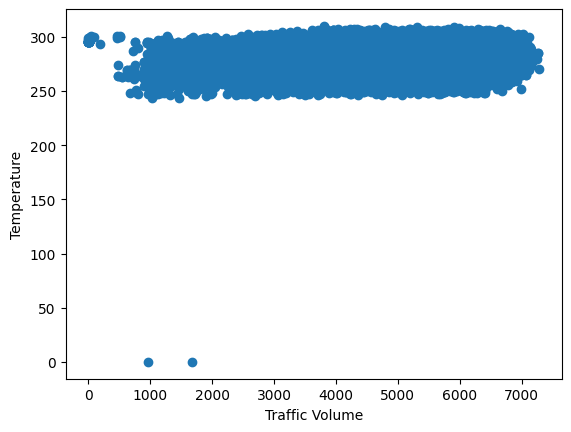

In [159]:
plt.scatter(daytime_traffic['traffic_volume'], daytime_traffic['temp'])
plt.xlabel('Traffic Volume')
plt.ylabel('Temperature')
plt.show()

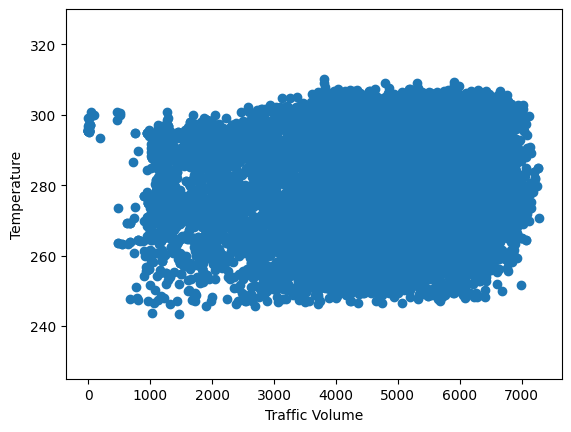

In [160]:
# let's get rid of the two outliers in temperature since an average of 0K makes no sense here.

plt.scatter(daytime_traffic['traffic_volume'], daytime_traffic['temp'])
plt.xlabel('Traffic Volume')
plt.ylabel('Temperature')
plt.ylim([225, 330])
plt.show()

From this visual, we can conclude that temperature is not a good indicator of heavy traffic.

### Weather Types

weather_main is a 'Categorical Short textual description of the current weather' as per the data documentation.

In [161]:
daytime_traffic['weather_main'].value_counts()

Clouds          8702
Clear           5744
Rain            2841
Mist            2593
Snow            1454
Drizzle          883
Haze             834
Thunderstorm     451
Fog              362
Smoke             12
Squall             1
Name: weather_main, dtype: int64

Let's look at average traffic volumes during these weather conditions.

In [162]:
by_weather_main = daytime_traffic.groupby('weather_main').mean(numeric_only = True)

by_weather_main['traffic_volume']

weather_main
Clear           4778.416260
Clouds          4865.415996
Drizzle         4837.212911
Fog             4372.491713
Haze            4609.893285
Mist            4623.976475
Rain            4815.568462
Smoke           4564.583333
Snow            4396.321183
Squall          4211.000000
Thunderstorm    4648.212860
Name: traffic_volume, dtype: float64

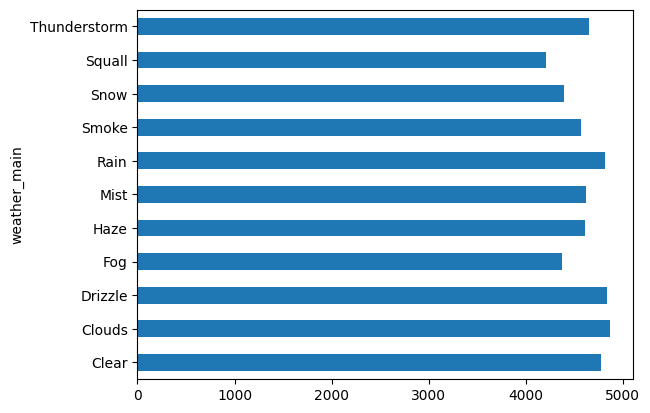

In [164]:
# create a bar plot for average traffic volume by weather_main

by_weather_main['traffic_volume'].plot.barh()
plt.show()

None of the weather_main categories is associated with traffic volumes spiking above 5000. So, there isn't an interesting indicator for heavy traffic here for us.

weather_description is a 'Categorical Longer textual description of the current weather'

In [165]:
by_weather_description = daytime_traffic.groupby('weather_description').mean(numeric_only = True)

by_weather_description['traffic_volume']

weather_description
SQUALLS                                4211.000000
Sky is Clear                           4919.009390
broken clouds                          4824.130326
drizzle                                4737.330935
few clouds                             4839.818023
fog                                    4372.491713
freezing rain                          4314.000000
haze                                   4609.893285
heavy intensity drizzle                4738.586207
heavy intensity rain                   4610.356164
heavy snow                             4411.681250
light intensity drizzle                4890.164049
light intensity shower rain            4558.100000
light rain                             4859.650849
light rain and snow                    5579.750000
light shower snow                      4618.636364
light snow                             4430.858896
mist                                   4623.976475
moderate rain                          4769.643312
overcast cl

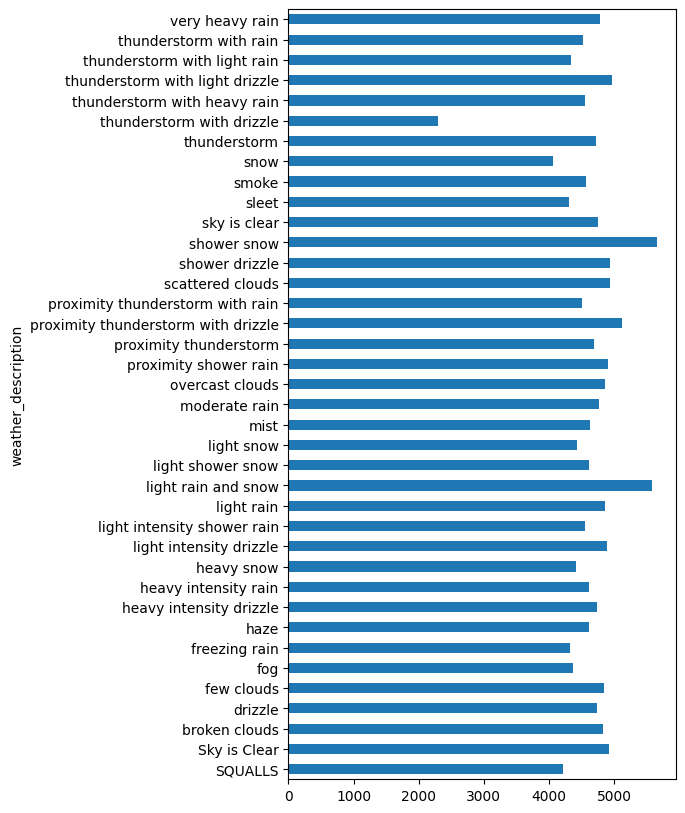

In [167]:
by_weather_description['traffic_volume'].plot.barh(figsize = (5, 10)) # without setting the figsize, the labels would overlap
plt.show()

The conditions 'shower snow' and 'light rain and snow' are associated with traffic volume spikes that exceed 5000 by more than 10%.

Theses two conditions make acceptable indicators for heavier traffic.

### Conclusion

To review, we found two types of indicators for heavier westbound traffic on the I-94 Interstate:

- Time indicators
    - The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
    - The traffic is usually heavier on business days compared to the weekends.
    - On business days, the rush hours are around 7 and 16.
- Weather indicators
    - Shower snow
    - Light rain and snow

### Next Steps

- Use the nighttime data to look for heavy traffic indicators.
- Find more time and weather indicators.
- Make your project portfolio-ready by following the dataquest style guide.